In [573]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from forecastingGDP.data import get_data,get_series_info,clear_cache
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.interpolate import interp1d
from sklearn.model_selection import TimeSeriesSplit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [574]:
df_m = get_data(frequency='MS', use_cache=True)
df_q = get_data('QS-Jan', use_cache=True)
df_w = get_data('W-Sun', use_cache=True)

In [575]:
df_w=df_w.loc[df_w.index>='1971-01']
df_w=df_w.loc[df_w.index<='2020-01']

In [576]:
data_info=[]
for i in df_w.columns:
    data_info.append(get_series_info(i))   

In [579]:
df_w.head()

,GDPC1,INDPRO,ATLSBUSRGEP,TCU,AMTMNO,DGORDER,CFNAI,UMCSENT,MARTSMPCSM44000USS,DSPIC96,...,IMPGSC1,EXPGSC1,IMPCH,BAMLH0A0HYM2,SP500,WILL5000INDFC,VIXCLS,GS10,GS2,DTWEXAFEGS
1971-01-03,5069.746000,37.70080,NaN,79.7621,NaN,NaN,0.53,NaN,NaN,3735.80,...,280.390,205.434000,NaN,NaN,NaN,NaN,NaN,6.240,NaN,NaN
1971-01-10,5071.856231,37.68644,NaN,79.6913,NaN,NaN,0.42,NaN,NaN,3736.82,...,282.017,205.317154,NaN,NaN,NaN,NaN,NaN,6.214,NaN,NaN
1971-01-17,5073.966462,37.67208,NaN,79.6205,NaN,NaN,0.31,NaN,NaN,3737.84,...,283.644,205.200308,NaN,NaN,NaN,NaN,NaN,6.188,NaN,NaN
1971-01-24,5076.076692,37.65772,NaN,79.5497,NaN,NaN,0.20,NaN,NaN,3738.86,...,285.271,205.083462,NaN,NaN,NaN,NaN,NaN,6.162,NaN,NaN
1971-01-31,5078.186923,37.64336,NaN,79.4789,NaN,NaN,0.09,NaN,NaN,3739.88,...,286.898,204.966615,NaN,NaN,NaN,1.05,NaN,6.136,NaN,NaN


In [580]:
data_info=pd.DataFrame(data_info)
data_info=data_info.set_index('id')

KeyError: "None of ['id'] are in the columns"

In [ ]:
#Info and Missing Values %
percent_missing = df_w.isnull().sum() * 100 / len(data)
observation_start=data_info['observation_start']
observation_end=data_info['observation_end']
frequency=data_info['frequency_short']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info

In [ ]:
for i in df_w.columns:
    if df_w[i].isna().sum()!=0:
        df_w=df_w.drop(columns=i)

In [ ]:
#Convert GDP to GDP change %
df_w['GDPC1']=df_w['GDPC1'].pct_change()

In [ ]:
df_w=df_w.dropna()

In [ ]:
#Info and Missing Values %
percent_missing = df_w.isnull().sum() * 100 / len(data)
observation_start=data_info['observation_start']
observation_end=data_info['observation_end']
frequency=data_info['frequency_short']

df_info = pd.DataFrame({
                        'observation_start':observation_start,
                        'observation_end':observation_end,
                        'frequency':frequency,
                        'percent_missing': percent_missing})

df_info=df_info.sort_values('percent_missing',ascending=False)
df_info.dropna()

In [ ]:
#Starting and ending date
print(f'Start: {df_w.index[0]}')
print(f'End: {df_w.index[-1]}')
print(f'Shape: {df_w.shape}')

In [ ]:
#Interpolation test on GDPC1
X=np.arange(0, len(df_q))
y=df_q['GDPC1'].dropna()
f = interp1d(X, y)
xnew = np.arange(0, len(df_q)-1, (1/3))
ynew = f(xnew)
plt.plot(X, y, 'o', xnew, ynew, '-')
plt.show()

In [ ]:
def interpolation():
    
    '''Create a linear interpolation of missing data'''
    for i in df_info.index:
        if df_info.loc[i]['frequency']=='Q':
            
            X=np.arange(0, len(data[i].dropna()))
            y=data[i].dropna()
            f = interp1d(X, y)
            xnew = np.arange(0, len(data[i].dropna())-1, (1/3))
            ynew = f(xnew)
            df_test.drop(columns=[i])
            df_test[i]=ynew
            
    return df_test

In [ ]:
corr = df_w.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap);

#### df_train & df_test split

In [ ]:
df_w

In [ ]:
# Time Serie split 
#We separate df into df_train and df_test such that the first 80% of the dataframe are in the training. 
#And the last 20% in the test set.

len_ = int(0.6*df_w.shape[0])
df_train = df_w[:len_]
df_test = df_w[len_:len_+int(len(df_w[len_:])/2)]
df_val=df_w[len_+int(len(df_w[len_:])/2):]
assert df_train.shape[0]+df_test.shape[0]+df_val.shape[0] == df_w.shape[0]

In [ ]:
# Scale
columns = df_w.columns

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_val_scaled=pd.DataFrame(scaler.transform(df_val), columns=columns)
df_train_scaled.head()

In [ ]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample


def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['GDPC1']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [ ]:
#Sequences has to be >100 for our model to train correctly
X_train, y_train = get_X_y(df_train_scaled, 500, 4)
print(X_train.shape)
print(y_train.shape)

In [ ]:
X_test, y_test = get_X_y(df_test_scaled, 100, 4)
print(X_test.shape)
print(y_test.shape)

In [ ]:
X_val, y_val = get_X_y(df_val_scaled, 100, 4)
print(X_val.shape)
print(y_val.shape)

In [ ]:
input_shape=X_train[0].shape

### RNN MODEL

In [ ]:
# Mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

In [ ]:
# Predict MAPE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

In [ ]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred_baseline-y_test))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

In [ ]:
# Predict MAE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test))
print(f'Benchmark MAE on the test set : {bench_res:.2f} %')

In [ ]:
# We here decide to predict the mean of the train set y_train
y_pred_baseline = np.mean(y_train)
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

In [ ]:
# Predict RMSE with last GDP value
y_pred_baseline = X_test[:,-1,0]
bench_res = np.sqrt(np.mean(np.square(y_pred_baseline-y_test)))
print(f'Benchmark RMSE on the test set : {bench_res:.4f}')

In [ ]:
input_shape=X_train.shape[1:]
input_shape

In [594]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.LSTM(50, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop', 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 3, 50)             13200     
_________________________________________________________________
lstm_45 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 6         
Total params: 18,991
Trainable params: 18,991
Non-trainable params: 0
_________________________________________________________________


In [595]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=16,
            verbose=0,
            callbacks=[es])

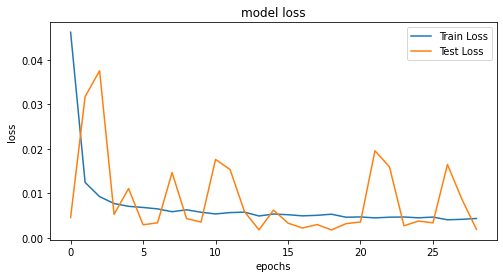

In [596]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [597]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.0347
MAPE on the test set: 50.0469
RMSE on the test set: 0.1862


In [598]:
y_pred=model.predict(X_test)

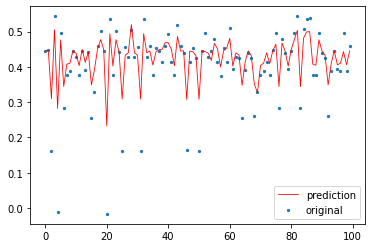

In [599]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()

In [600]:
def init_model():
    
    model = models.Sequential()

    model.add(layers.GRU(20, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.GRU(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae','mape'])
    
    return model

init_model().summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 3, 20)             2220      
_________________________________________________________________
gru_29 (GRU)                 (None, 10)                960       
_________________________________________________________________
dense_68 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 6         
Total params: 3,241
Trainable params: 3,241
Non-trainable params: 0
_________________________________________________________________


In [585]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(patience=10,restore_best_weights=True)
model = init_model()



history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=1000, 
            batch_size=32,
            verbose=0,
            callbacks=[es])

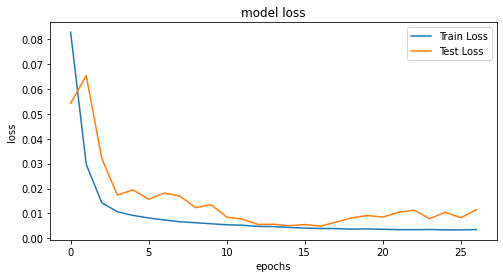

In [586]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [587]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')
print(f'MAPE on the test set: {res[2]:.4f}')
print(f'RMSE on the test set: {res[1]**0.5:.4f}')

MAE on the test set : 0.0832
MAPE on the test set: 100.2824
RMSE on the test set: 0.2885


In [588]:
y_pred=model.predict(X_test)

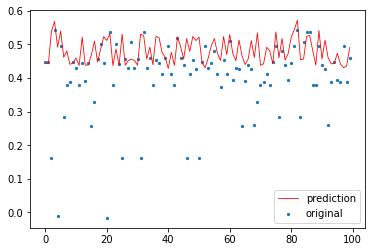

In [589]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5,label='original')
plt.plot(x_ax, y_pred, lw=0.8,color='r',label='prediction')
plt.legend()
plt.show()